In [9]:
import pandas as pd
import seaborn as sns
import time
import xgboost
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_validate
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

sns.set_theme(style="whitegrid")
sns.set_palette(palette="Paired")
SEED: int = 42

# Load Data
We load the already processed data from the `data/processed` directory

In [10]:
X_train = pd.read_csv("../../data/processed/train_data_cleaned.csv", index_col="building_id")
y_train = pd.read_csv("../../data/processed/train_labels.csv", index_col="building_id", usecols=["building_id", "damage_grade"])
X_train.head(5)

,count_families,count_floors_pre_eq,geo_level_1_id,geo_level_2_id,geo_level_3_id,has_secondary_use,has_superstructure_cement_mortar_brick,has_superstructure_mud_mortar_stone,age,area_percentage,superstructure_quality,foundation_type_r,ground_floor_type_f,ground_floor_type_v,land_surface_condition_t,other_floor_type_q,position_s,roof_type_n
building_id,,,,,,,,,,,,,,,,,,
802906,0.111111,0.125,0.200000,0.341275,0.970637,0.0,0.0,1.0,0.121343,0.247589,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0
28830,0.111111,0.125,0.266667,0.630694,0.223761,0.0,0.0,1.0,0.040448,0.346625,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
94947,0.111111,0.125,0.700000,0.254380,0.714013,0.0,0.0,1.0,0.040448,0.198071,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
590882,0.111111,0.125,0.733333,0.292922,0.850959,0.0,0.0,1.0,0.040448,0.247589,0.5,1.0,1.0,0.0,1.0,0.0,1.0,1.0
201944,0.111111,0.250,0.366667,0.091801,0.118405,0.0,0.0,0.0,0.121343,0.346625,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0


In [11]:
y_train.head(5)

,damage_grade
building_id,
802906,3
28830,2
94947,3
590882,2
201944,3


In [12]:
# Take subsample for PC to handle better
X_train = X_train.iloc[:10000]
y_train = y_train.iloc[:10000]

# Model Experimenting: Stacking
In this section we try out a stacking classifier using multiple classifiers with different paradigms.

In [13]:
def get_cross_validate_results(clf, cv=5):
    """
    Function to cross validate a given classifier.
    :param clf: Classifier, e.g. RandomForest Object
    :param cv: Number of k-folds
    :return: cv_results -- Dictionary of the cross validation results
    """
    start_time = time.time()

    # Label encode y_train for Xgboost (expects 0, 1, 2, not 1, 2, 3)
    if isinstance(clf, xgboost.XGBClassifier):
        encoder = LabelEncoder()
        y_train_encoded = encoder.fit_transform(y_train["damage_grade"].to_numpy())
        cv_results = cross_validate(clf,
                                    X_train,
                                    y_train_encoded,
                                    cv=cv,
                                    scoring=["matthews_corrcoef", "accuracy"],
                                    n_jobs=-1,
                                    return_train_score=True)
    else:
        cv_results = cross_validate(clf,
                                    X_train,
                                    y_train["damage_grade"].ravel(),
                                    cv=cv,
                                    scoring=["matthews_corrcoef", "accuracy"],
                                    n_jobs=-1,
                                    return_train_score=True)
    end_time = time.time()
    print(f"Time elapsed for CV: {(end_time - start_time):.2f}s of {str(clf)}")
    return cv_results


def plot_cv_results(cv_results:dict, classifier:str):
    """
    Plots the cv_results dictionary for a better comparsion.
    :param cv_results:
    :param classifier:
    :return:
    """
    k_folds = len(cv_results.get("test_matthews_corrcoef"))

    # Get mean of mcc, acc and fit time and std
    mean_fit_time = np.mean(cv_results.get("fit_time"))
    mean_mcc = np.mean(cv_results.get("test_matthews_corrcoef"))
    std_mcc = np.std(cv_results.get("test_matthews_corrcoef"))
    mean_acc = np.mean(cv_results.get("test_accuracy"))
    std_acc = np.std(cv_results.get("test_accuracy"))

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4), dpi=256)
    fig.suptitle(f"CV Results of {classifier} (mean_fit_time = {mean_fit_time:.2f}s)", size=18, fontweight='bold')
    sns.barplot(x=np.arange(1, k_folds+1),
                y=cv_results.get("test_matthews_corrcoef"),
                ax=axes[0], edgecolor="black")
    axes[0].set_title(f"Test MCC in each fold ($\mu = {mean_mcc:.4f}, \sigma = {std_mcc:.4f}$)", size=16)
    axes[0].set_xlabel("$k$-fold")
    axes[0].set_ylabel("MCC")

    sns.barplot(x=np.arange(1, k_folds+1),
                y=cv_results.get("test_accuracy"),
                ax=axes[1], edgecolor="black")
    axes[1].set_title(f"Test ACC in each fold ($\mu = {mean_acc:.4f}, \sigma = {std_acc:.4f}$)", size=16)
    axes[1].set_xlabel("$k$-fold")
    axes[1].set_ylabel("ACC")
    plt.tight_layout()
    plt.show()

Time elapsed for CV: 8.09s of GradientBoostingClassifier(random_state=42)


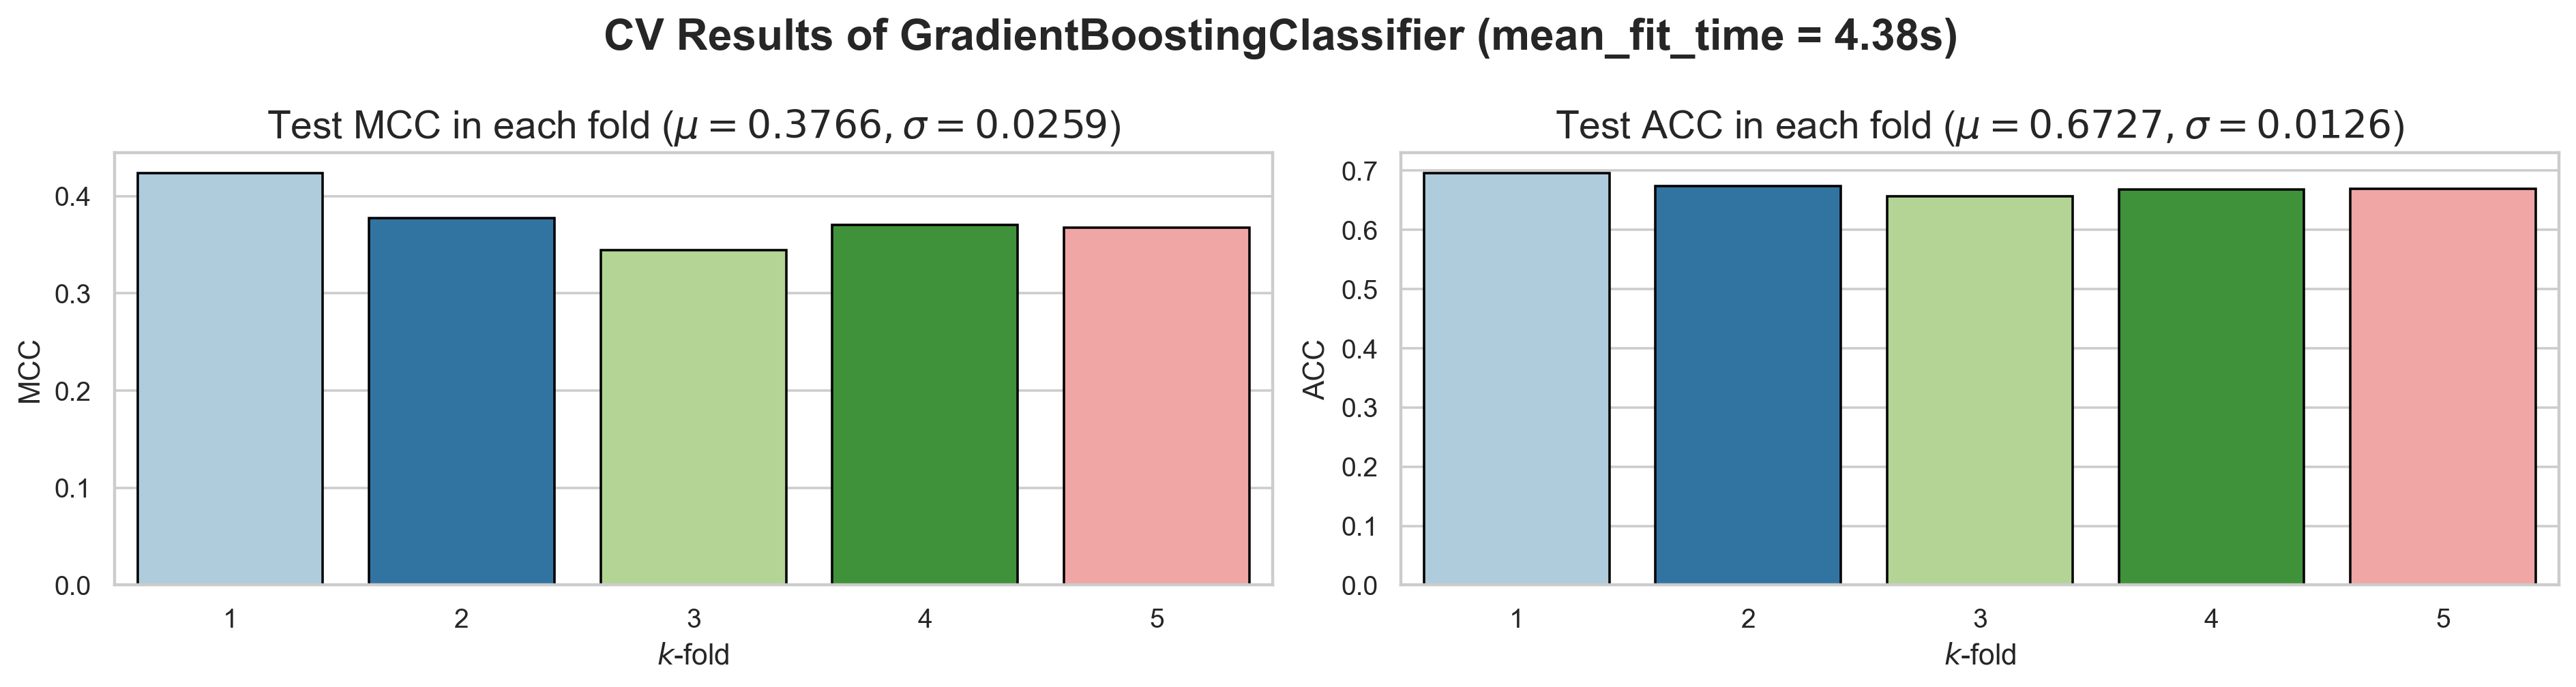

In [14]:
# GradientBoosting
gbc = GradientBoostingClassifier(random_state=42)
gbc_results = get_cross_validate_results(gbc)
plot_cv_results(gbc_results, "GradientBoostingClassifier")

Time elapsed for CV: 8.24s of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)


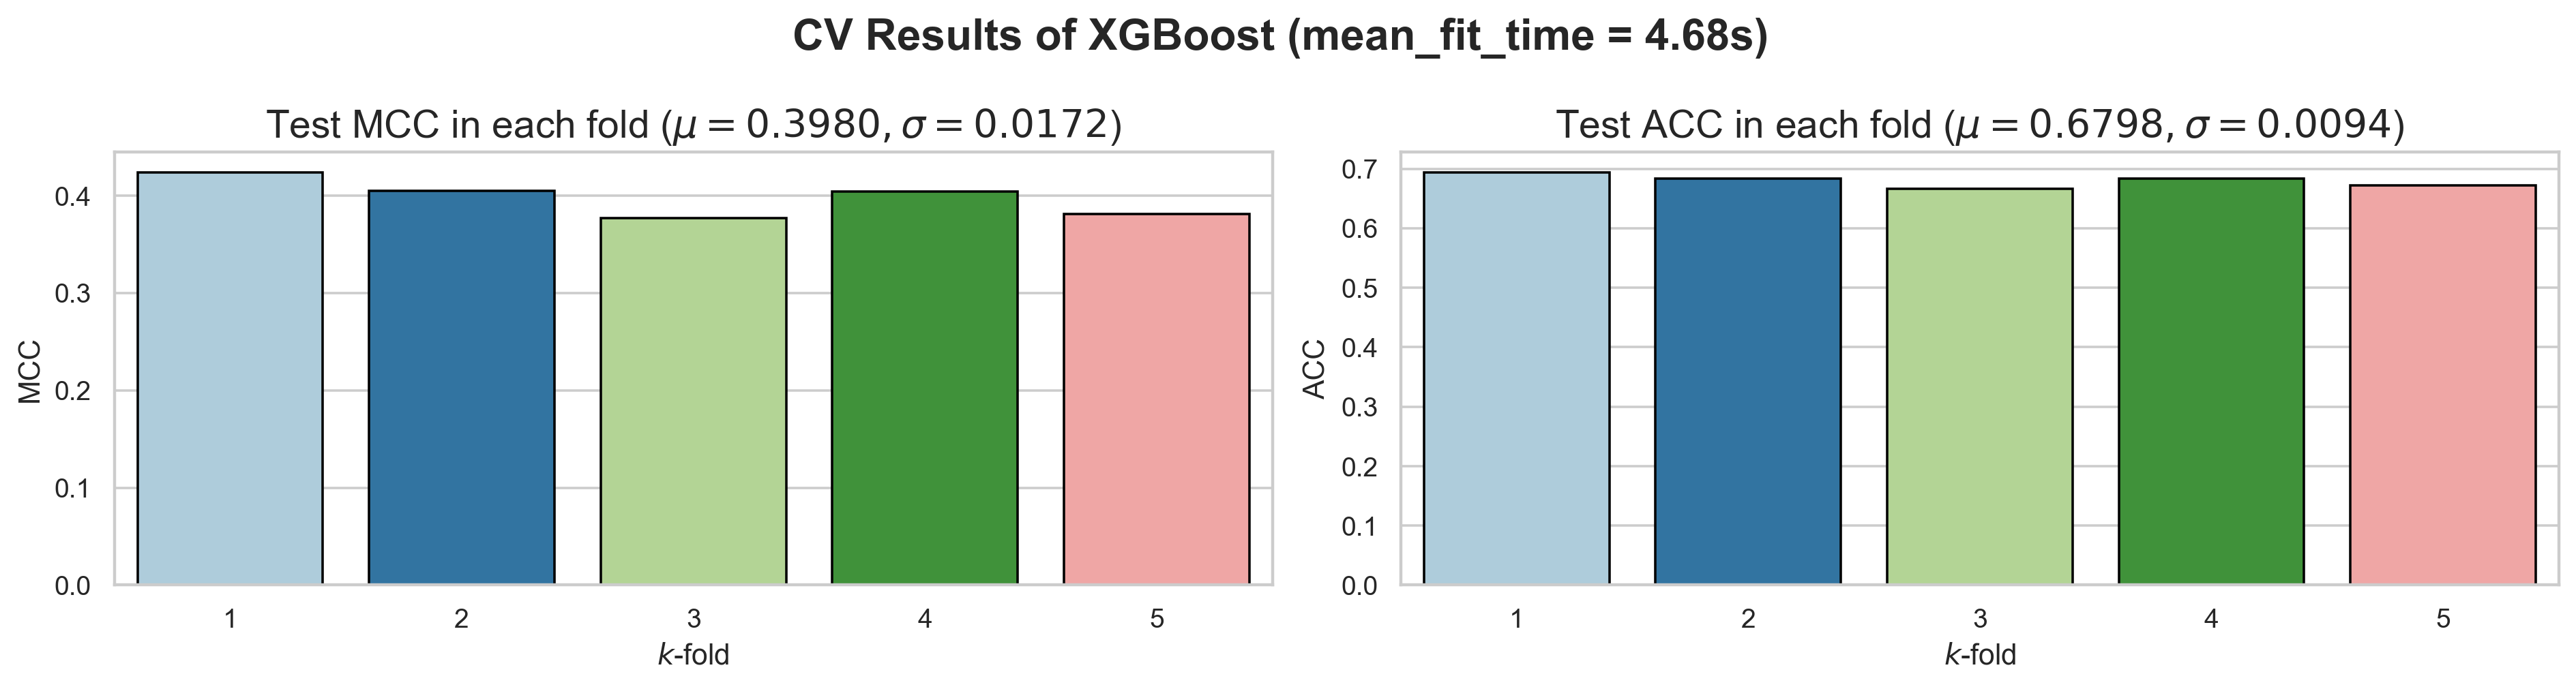

In [15]:
# XGB Boost
xgb = xgboost.XGBClassifier(random_state=42, n_jobs=-1)
xgb_results = get_cross_validate_results(xgb)
plot_cv_results(xgb_results, "XGBoost")

## Stacking

Epoch 1, change: 1.00000000
Epoch 2, change: 0.20220661
Epoch 3, change: 0.19087268
Epoch 4, change: 0.11582923
Epoch 5, change: 0.07798382
Epoch 6, change: 0.06032018
Epoch 7, change: 0.03451736
Epoch 8, change: 0.02123400
Epoch 9, change: 0.01488189
Epoch 10, change: 0.00664356
Epoch 11, change: 0.00705549
Epoch 12, change: 0.00429019
Epoch 13, change: 0.00389444
Epoch 14, change: 0.00243650
Epoch 15, change: 0.00187211
Epoch 16, change: 0.00127162
Epoch 17, change: 0.00087316
Epoch 18, change: 0.00074448
Epoch 19, change: 0.00043167
Epoch 20, change: 0.00025146
Epoch 21, change: 0.00019906
Epoch 1, change: 1.00000000
Epoch 2, change: 0.38099682
Epoch 3, change: 0.18363760
Epoch 4, change: 0.13070820
Epoch 5, change: 0.07800512
Epoch 6, change: 0.04426016
Epoch 7, change: 0.03466210
Epoch 8, change: 0.02284776
Epoch 9, change: 0.01349051
Epoch 10, change: 0.00845064
Epoch 11, change: 0.00855673
Epoch 12, change: 0.00544063
Epoch 13, change: 0.00297457
Epoch 14, change: 0.00223998
Epo

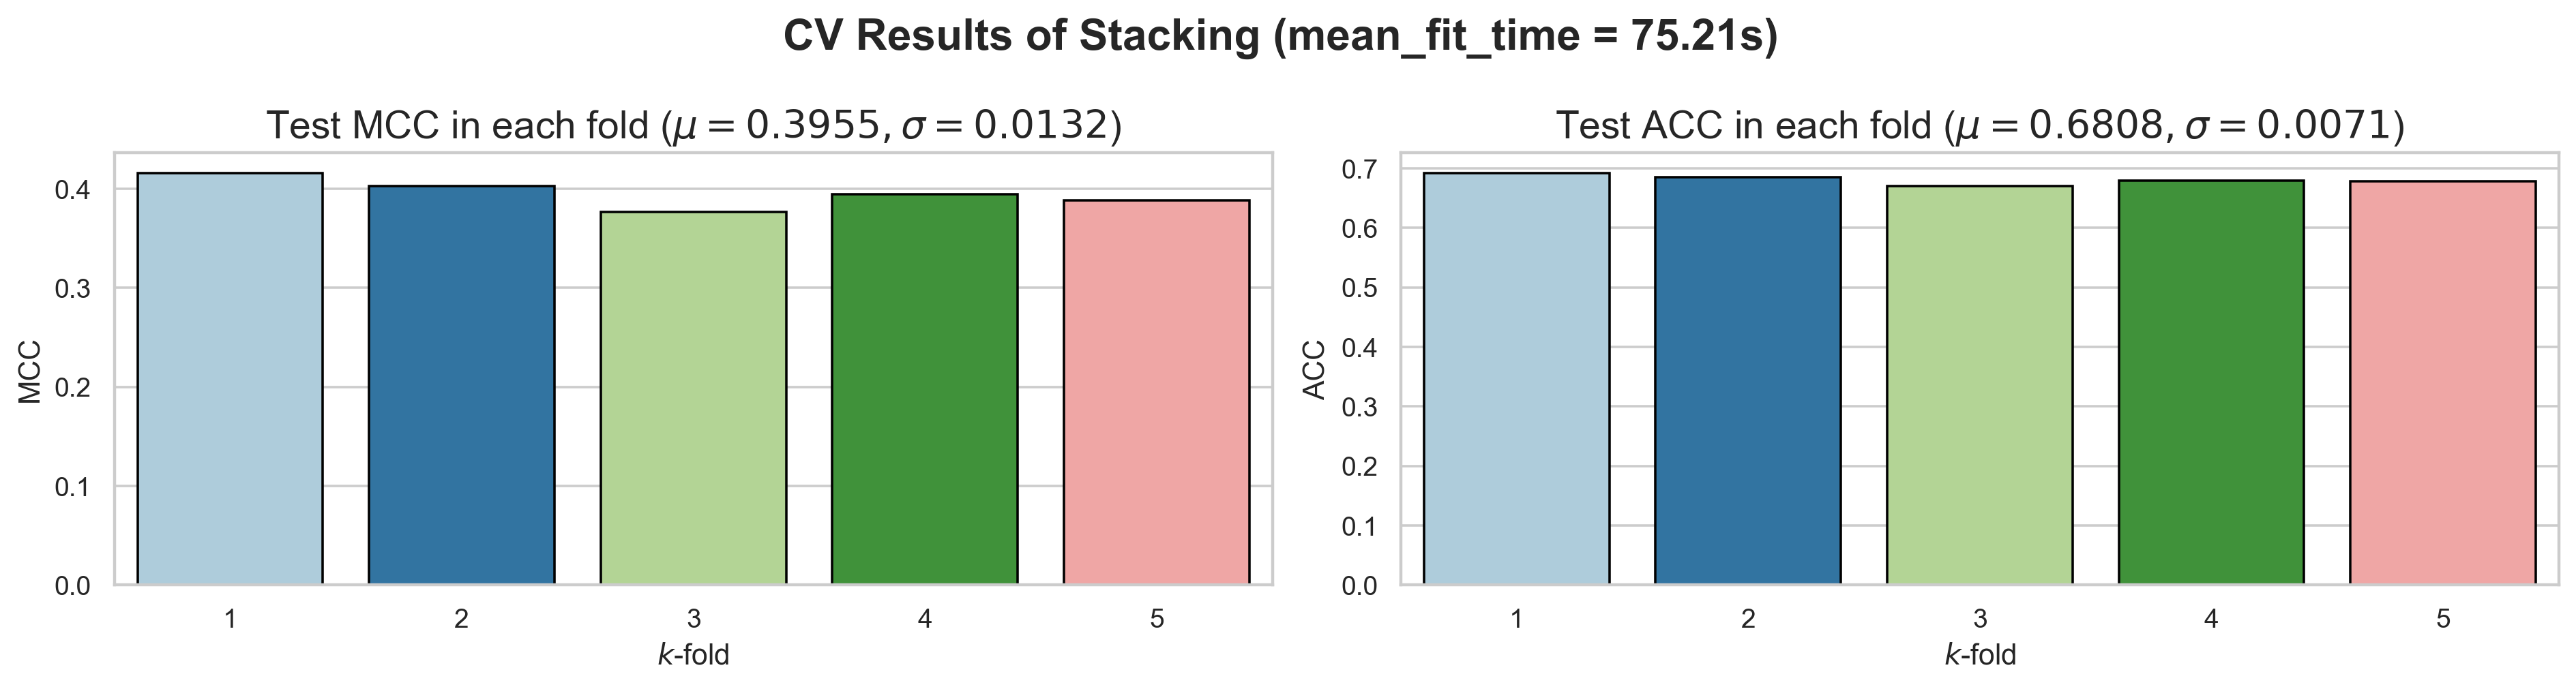

In [16]:
svc = SVC(random_state=42)
rf = RandomForestClassifier(random_state=42)
logit = LogisticRegression(penalty="l2", verbose=True, solver="saga", random_state=SEED)

estimators = [("rf", rf),
              ("svc", svc),
              ("xgb", xgb),
              ("logit", logit)]

stacking_clf = StackingClassifier(estimators=estimators, n_jobs=-1)
stacking_clf_results = get_cross_validate_results(stacking_clf)
plot_cv_results(stacking_clf_results, "Stacking")